In [1]:
!pip install -q kagglehub
!pip install -q python-dotenv
!pip install -q -U albumentations

In [2]:
import os
from dotenv import load_dotenv
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import kagglehub
import glob
import albumentations as A
import re
import tensorflow.keras.backend as K
import math

# SET ENVIRONMENT

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the correct path
dotenv_path = "/content/drive/MyDrive/Colab Notebooks/.env"

# Load the .env file
load_dotenv(dotenv_path)

# Set Kaggle credentials for kagglehub
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

Mounted at /content/drive


# DOWNLOAD DATASET

In [4]:
# Download latest version
path = kagglehub.dataset_download("ultralytics/brain-tumor")

print("Path to dataset files:", path)
print("Files in dataset folder:", os.listdir(path))

100%|██████████| 4.19M/4.19M [00:01<00:00, 3.28MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2
Files in dataset folder: ['brain-tumor', 'brain-tumor.yaml']


# DATA PREPROCESSING

In [5]:
IMG_SIZE = 224       # Size to which images are resized (224x224)
BATCH_SIZE = 32      # Batch size for training (used later in model training)
N = 3                # Fixed number of bounding boxes per image

TRAIN_IMAGES_PATH = os.path.join(path,"brain-tumor/train/images")
TRAIN_LABELS_PATH = os.path.join(path,"brain-tumor/train/labels")
VALID_IMAGES_PATH = os.path.join(path,"brain-tumor/valid/images")
VALID_LABELS_PATH = os.path.join(path,"brain-tumor/valid/labels")

cnn1_images_path = "/content/cnn1"
cnn2_images_path = "/content/cnn2"

# Create an empty DataFrame for cnn1
cnn1_train_df = pd.DataFrame(columns=["Image Name", "Image Path", "Class Ids", "Bboxes", "Confidence Scores"])
cnn1_valid_df = pd.DataFrame(columns=["Image Name", "Image Path", "Class Ids", "Bboxes", "Confidence Scores"])

# Create an empty DataFrame for cnn2
cnn2_train_df = pd.DataFrame(columns=["Image Name", "Image Path", "Class Id"])
cnn2_valid_df = pd.DataFrame(columns=["Image Name", "Image Path", "Class Id"])

def add_to_cnn1_train_df(image_name, image_path, class_ids, bboxes, confidence_scores):
  global cnn1_train_df # Ensure we modify the global dataframe
  #Append a new row
  new_row = pd.DataFrame({'Image Name': [image_name],
                          'Image Path': [image_path],
                          'Class Ids': [class_ids],
                          'Bboxes':[bboxes],
                          'Confidence Scores':[confidence_scores]})
  cnn1_train_df = pd.concat([cnn1_train_df, new_row], ignore_index=True)

def add_to_cnn1_valid_df(image_name, image_path, class_ids, bboxes, confidence_scores):
  global cnn1_valid_df # Ensure we modify the global dataframe
  #Append a new row
  new_row = pd.DataFrame({'Image Name': [image_name],
                          'Image Path': [image_path],
                          'Class Ids': [class_ids],
                          'Bboxes':[bboxes],
                          'Confidence Scores':[confidence_scores]})
  cnn1_valid_df = pd.concat([cnn1_valid_df, new_row], ignore_index=True)

def add_to_cnn2_train_df(image_name, image_path, class_id):
  global cnn2_train_df # Ensure we modify the global dataframe
  #Append a new row
  new_row = pd.DataFrame({'Image Name': [image_name],
                          'Image Path': [image_path],
                          'Class Id': [class_id]})
  cnn2_train_df = pd.concat([cnn2_train_df, new_row], ignore_index=True)

def add_to_cnn2_valid_df(image_name, image_path, class_id):
  global cnn2_valid_df # Ensure we modify the global dataframe
  #Append a new row
  new_row = pd.DataFrame({'Image Name': [image_name],
                          'Image Path': [image_path],
                          'Class Id': [class_id]})
  cnn2_valid_df = pd.concat([cnn2_valid_df, new_row], ignore_index=True)

In [6]:
# Define the new folder structure
base_dirs = [cnn1_images_path,cnn2_images_path]
sub_dirs = ["train", "valid"]

# Create both folders with subdirectories
for base_dir in base_dirs:
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(base_dir, sub_dir), exist_ok=True)

print("Folders cnn1 and cnn2 with subfolders train and valid have been created.")

Folders cnn1 and cnn2 with subfolders train and valid have been created.


In [7]:
max_bboxes = 0  # Initialize max count

label_files = glob.glob(os.path.join(TRAIN_LABELS_PATH, "*.txt"))  # Get all label files

for label_file in label_files:
    with open(label_file, "r") as f:
        lines = f.readlines()
        bbox_count = len(lines)  # Number of bounding boxes in this image
        max_bboxes = max(max_bboxes, bbox_count)  # Update max if this is greater

print(f"Maximum bounding boxes in a single image: {max_bboxes}")

Maximum bounding boxes in a single image: 3


## Helper Functions

In [8]:
cnn1_augment = A.Compose([
    A.HorizontalFlip(p=0.5),                  # 50% chance to flip horizontally. Tumors can appear on either side of the brain. This simulates left-right variability
    A.RandomBrightnessContrast(p=0.2),        # Adjust brightness/contrast with 20% probability. It simulates different imaging conditions (e.g., variations in scanner settings), helping the model become robust to changes in lighting.
    A.Rotate(limit=15, p=0.3),                # Rotate by a small angle (±15°) with 30% probability. MRI scans may have slight angular differences due to patient positioning. Small rotations ensure the model learns to recognize tumors even if they're not perfectly aligned.
    A.GaussianBlur(p=0.1)                     # Simulates minor noise or imperfections in imaging. It can help the model generalize better by not overfitting to overly sharp features.
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])) # Format-"pascal-voc" indicates that the bounding boxes are in the (x1, y1, x2, y2) format.
                                      # The label_fields parameter tells which additional data (beyond the bounding boxes) should be kept in sync with the transformations.

def enforce_N_constraint(class_ids, bboxes, confidence_scores):
    while len(bboxes) < N:
        class_ids.append("NA")
        bboxes.append([0, 0, 0, 0])  # Empty bounding box
        confidence_scores.append(0)  # No object

    # If more than N, truncate (rare case)
    return class_ids[:N], bboxes[:N], confidence_scores[:N]

def process_annotations(label_path):
  with open(label_path, "r") as f:
      lines = f.readlines()

  class_ids = []
  bboxes = []
  confidence_scores = []

  for line in lines:
      class_id, x_center, y_center, box_width, box_height = map(float, line.split())

      # Scale and position the center to the resized image dimensions (IMG_SIZE) in pixels.
      x_center_new = (x_center * IMG_SIZE)
      y_center_new = (y_center * IMG_SIZE)
      box_width_new = (box_width * IMG_SIZE)
      box_height_new = (box_height * IMG_SIZE)

      # Convert from YOLO format to (x1, y1, x2, y2)
      x1 = x_center_new - (box_width_new / 2)
      y1 = y_center_new - (box_height_new / 2)
      x2 = x_center_new + (box_width_new / 2)
      y2 = y_center_new + (box_height_new / 2)

      class_ids.append(int(class_id))

      bboxes.append([x1,y1,x2,y2])
      confidence_scores.append(1)  # 1 = True bounding box

  return class_ids, bboxes, confidence_scores

def load_cnn1_dataset(image_dir, label_dir, data_type):
  image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

  for image_path in image_paths:
      # Derive label path from image path
      label_path= image_path.replace("images", "labels").replace(".jpg", ".txt")

      if not os.path.exists(label_path):
        continue  # Skip this image if its label file is missing

      image = cv2.imread(image_path)
      image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize

      # Extract bounding boxes and class ids YOLO labels
      class_ids, bboxes, confidence_scores = process_annotations(label_path)

      # Apply Augmentation
      augmented = cnn1_augment(image=image_resized, bboxes=bboxes, class_labels=class_ids)
      bboxes_aug = augmented["bboxes"]

      # Normalizing the bboxes to a range of [0..1] and rounding to 6 decimals
      bboxes = [[round(x1/IMG_SIZE,6), round(y1/IMG_SIZE,6), round(x2/IMG_SIZE,6), round(y2/IMG_SIZE,6)] for x1, y1, x2, y2 in bboxes]
      bboxes_aug = [[round(x1/IMG_SIZE,6), round(y1/IMG_SIZE,6), round(x2/IMG_SIZE,6), round(y2/IMG_SIZE,6)] for x1, y1, x2, y2 in augmented["bboxes"]]

       # Ensure N number of bounding boxes-add padding on both resized and augmented image
      class_ids, bboxes, confidence_scores = enforce_N_constraint(class_ids, bboxes, confidence_scores)
      _, bboxes_aug, _ = enforce_N_constraint(class_ids, bboxes_aug, confidence_scores)

      # Add the resized and augmented image to cnn1 folder
      image_name = os.path.basename(image_path)
      image_save_path = os.path.join(cnn1_images_path,data_type,image_name)
      cv2.imwrite(image_save_path, image_resized)  # Save the image - (filename (with full path here),image)

      image_name_aug = image_name.replace(".jpg", "_aug.jpg")  # Rename file
      image_save_path_aug = os.path.join(cnn1_images_path, data_type, image_name_aug)
      cv2.imwrite(image_save_path_aug, augmented["image"])

      # Add the resized and augmented image info to the respective dataframe
      if data_type == "train":
        add_to_cnn1_train_df(image_name,image_save_path,class_ids,bboxes,confidence_scores)
        add_to_cnn1_train_df(image_name_aug, image_save_path_aug, class_ids, bboxes_aug, confidence_scores)
      else:
        add_to_cnn1_valid_df(image_name,image_save_path,class_ids,bboxes,confidence_scores)
        add_to_cnn1_valid_df(image_name_aug, image_save_path_aug, class_ids, bboxes_aug, confidence_scores)

In [9]:
def load_cnn2_dataset(df, data_type):

  for index, row in df.iterrows():
    # Get bounding boxes and class IDs
    bboxes = row["Bboxes"]
    class_ids = row["Class Ids"]

    for i, bbox in enumerate(bboxes):
      if bbox == [0, 0, 0, 0]:  # Ignore padding boxes
            continue

      image = cv2.imread(row["Image Path"])
      x1, y1, x2, y2 =bbox
      # Convert to pixel coordinates
      x1 = int(x1 * IMG_SIZE)
      x2 =  int(x2 * IMG_SIZE)
      y1 =  int(y1 * IMG_SIZE)
      y2 =  int(y2 * IMG_SIZE)
      cropped_image = image[y1:y2, x1:x2]  # Crop using array slicing
      cropped_image = cv2.resize(cropped_image, (96, 96), interpolation=cv2.INTER_LANCZOS4)  # Resize - To make it a bit larger but not too large that it becomes distorted. And interpolation to preserve clear features after resizing

      # Add the resized and augmented image to cnn2 folder
      image_name = os.path.basename(row["Image Path"])
      cropped_image_name = image_name.replace(".jpg", f"_crop_{i+1}.jpg")
      image_save_path = os.path.join(cnn2_images_path,data_type,cropped_image_name)
      cv2.imwrite(image_save_path, cropped_image)  # Save the image - (filename (with full path here),image)
      class_id = class_ids[i]

      # Add the resized and augmented image info to the respective dataframe
      if data_type == "train":
        add_to_cnn2_train_df(cropped_image_name,image_save_path,class_id)
      else:
        add_to_cnn2_valid_df(cropped_image_name,image_save_path,class_id)

In [10]:
def load_original_image(image_name, data_type):
  image_path = os.path.join(path,"brain-tumor",data_type,"images",image_name)
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV loads images in BGR (Blue, Green, Red) format by default. But Matplotlib (plt.imshow) expects RGB format.
  h, w, _ = image.shape
  label_path= image_path.replace("images", "labels").replace(".jpg", ".txt")
  with open(label_path, "r") as f:
    lines = f.readlines()

  for line in lines:
    class_id, x_center, y_center, box_width, box_height = map(float, line.split())

    # Scale and position the center to the original image dimensions in pixels.
    x_center = (x_center * w)
    y_center = (y_center * h)
    box_width = (box_width * w)
    box_height = (box_height * h)

    # Convert from YOLO format to (x1, y1, x2, y2)
    x1 = x_center - (box_width / 2)
    y1 = y_center - (box_height / 2)
    x2 = x_center + (box_width / 2)
    y2 = y_center + (box_height / 2)

    color = (255, 0, 0) if class_id == 1 else (0, 255, 0)  # Red for 1, Green for 0
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 1) #OpenCV's cv2.rectangle() only accepts integer coordinates

  return image

def load_and_draw_bboxes(row):
    image_path = row["Image Path"]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get bounding boxes and class IDs
    bboxes = row["Bboxes"]
    class_ids = row["Class Ids"]

    # Draw bounding boxes
    for i, bbox in enumerate(bboxes):
        if bbox == [0, 0, 0, 0]:  # Ignore padding boxes
            continue

        x1, y1, x2, y2 = bbox
        # Convert to pixel coordinates
        x1 = int(x1 * IMG_SIZE)
        y1 = int(y1 * IMG_SIZE)
        x2 = int(x2 * IMG_SIZE)
        y2 = int(y2 * IMG_SIZE)
        color = (255, 0, 0) if class_ids[i] == 1 else (0, 255, 0)  # Red for 1, Green for 0
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 1)

    return image

def visualize_random_image(cnn1_df,cnn2_df):
    # Filter out only resized images (those that do NOT end with "_aug.jpg")
    Resized_images = cnn1_df[~cnn1_df["Image Name"].str.endswith("_aug.jpg")]["Image Name"].unique()

    if len(Resized_images) == 0:
        print("No resized images found.")
        return

    # Randomly select a resized image
    image_name = random.choice(Resized_images) #"78 (2).jpg"

    # Find its corresponding augmented image
    image_name_aug = image_name.replace(".jpg", "_aug.jpg")

    #Find its corresponding cropped images in cnn2 df
    base_image_name = image_name.replace(".jpg", "") # Extracting just 125 from 125.jpg, else it would search fro 125.jpg in cnn2 df
    pattern = f"^{re.escape(base_image_name)}(_aug)?_crop_\\d+\\.jpg$" # ^: Matches the beginning of the filename; re.escape(base_image_name): Matches the exact base_image_name; (_aug)?: Optionally matches "_aug"; _crop_\d+: Ensures "crop" followed by a number is next; \.jpg$: Ensures the filename ends precisely with ".jpg"
    cropped_images_df = cnn2_df[cnn2_df["Image Name"].str.match(pattern)]
    cropped_image_paths = cropped_images_df["Image Path"].tolist()

    # Get rows for resized and augmented images
    row_resized = cnn1_df[cnn1_df["Image Name"] == image_name].iloc[0]
    row_augmented = cnn1_df[cnn1_df["Image Name"] == image_name_aug].iloc[0]

    # Load images with bounding boxes
    if cnn1_df["Image Path"].str.contains("train").any():
      img_original = load_original_image(image_name,"train")
    else:
      img_original = load_original_image(image_name,"valid")

    img_resized = load_and_draw_bboxes(row_resized)
    img_augmented = load_and_draw_bboxes(row_augmented)

    # Plot images side by side
    total_images = 3 + len(cropped_image_paths)
    fig, axes = plt.subplots(1, total_images, figsize=(5 * total_images, 6))

    axes[0].imshow(img_original)
    axes[0].set_title(f"Original: {image_name}")
    axes[0].axis("off")

    axes[1].imshow(img_resized)
    axes[1].set_title(f"Resized: {image_name}")
    axes[1].axis("off")

    axes[2].imshow(img_augmented)
    axes[2].set_title(f"Augmented: {image_name_aug}")
    axes[2].axis("off")

    # Cropped images from cnn2_df
    for idx, crop_img_path in enumerate(cropped_image_paths):
      cropped_img = cv2.imread(crop_img_path)
      cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
      axes[3 + idx].imshow(cropped_img)
      cropped_name = os.path.basename(crop_img_path)
      axes[3 + idx].set_title(f"Cropped: {cropped_name}")
      axes[3 + idx].axis("off")

    plt.suptitle("Original → Resized → Augmented → Cropped images")
    plt.show()

## Load Dataset

In [11]:
# Load the datasets
print("Loading CNN1 training dataset...")
load_cnn1_dataset(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH,"train")
print("CNN1 Training dataset size:", cnn1_train_df.shape)

print("Loading CNN1 validation dataset...")
load_cnn1_dataset(VALID_IMAGES_PATH, VALID_LABELS_PATH,"valid")
print("CNN1 Validation dataset size:", cnn1_valid_df.shape)

Loading CNN1 training dataset...
CNN1 Training dataset size: (1756, 5)
Loading CNN1 validation dataset...
CNN1 Validation dataset size: (446, 5)


In [12]:
print("Loading CNN2 training dataset...")
load_cnn2_dataset(cnn1_train_df,"train")
print("CNN2 Training dataset size:", cnn2_train_df.shape)

print("Loading CNN2 validation dataset...")
load_cnn2_dataset(cnn1_valid_df,"valid")
print("CNN2 Validation dataset size:", cnn2_valid_df.shape)

Loading CNN2 training dataset...
CNN2 Training dataset size: (1850, 3)
Loading CNN2 validation dataset...
CNN2 Validation dataset size: (482, 3)


In [13]:
cnn1_train_df.head()

,Image Name,Image Path,Class Ids,Bboxes,Confidence Scores
0,76 (9).jpg,/content/cnn1/train/76 (9).jpg,"[1, NA, NA, NA, NA]","[[0.597418, 0.26291, 0.725352, 0.444835], [0, ...","[1, 0, 0, 0, 0]"
1,76 (9)_aug.jpg,/content/cnn1/train/76 (9)_aug.jpg,"[1, NA, NA, NA, NA]","[[0.274648, 0.262911, 0.402582, 0.444835], [0,...","[1, 0, 0, 0, 0]"
2,63 (6).jpg,/content/cnn1/train/63 (6).jpg,"[1, NA, NA, NA, NA]","[[0.33568, 0.257043, 0.421361, 0.380282], [0, ...","[1, 0, 0, 0, 0]"
3,63 (6)_aug.jpg,/content/cnn1/train/63 (6)_aug.jpg,"[1, NA, NA, NA, NA]","[[0.599503, 0.275872, 0.70658, 0.412879], [0, ...","[1, 0, 0, 0, 0]"
4,00183_126.jpg,/content/cnn1/train/00183_126.jpg,"[0, NA, NA, NA, NA]","[[0.402582, 0.362676, 0.57277, 0.514084], [0, ...","[1, 0, 0, 0, 0]"


In [14]:
cnn2_train_df.head()

,Image Name,Image Path,Class Id
0,76 (9)_crop_1.jpg,/content/cnn2/train/76 (9)_crop_1.jpg,1
1,76 (9)_aug_crop_1.jpg,/content/cnn2/train/76 (9)_aug_crop_1.jpg,1
2,63 (6)_crop_1.jpg,/content/cnn2/train/63 (6)_crop_1.jpg,1
3,63 (6)_aug_crop_1.jpg,/content/cnn2/train/63 (6)_aug_crop_1.jpg,1
4,00183_126_crop_1.jpg,/content/cnn2/train/00183_126_crop_1.jpg,0


## Visualize Dataset

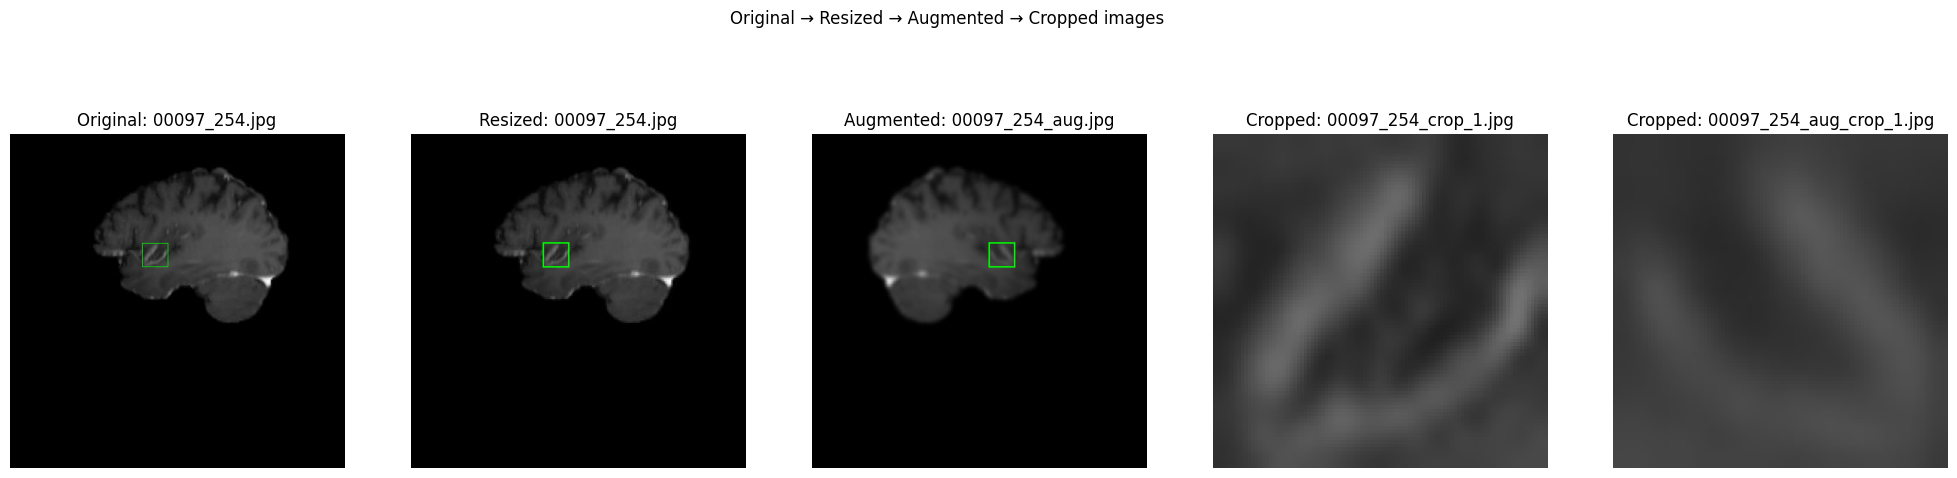

In [15]:
# Visualize a random image
visualize_random_image(cnn1_train_df, cnn2_train_df)

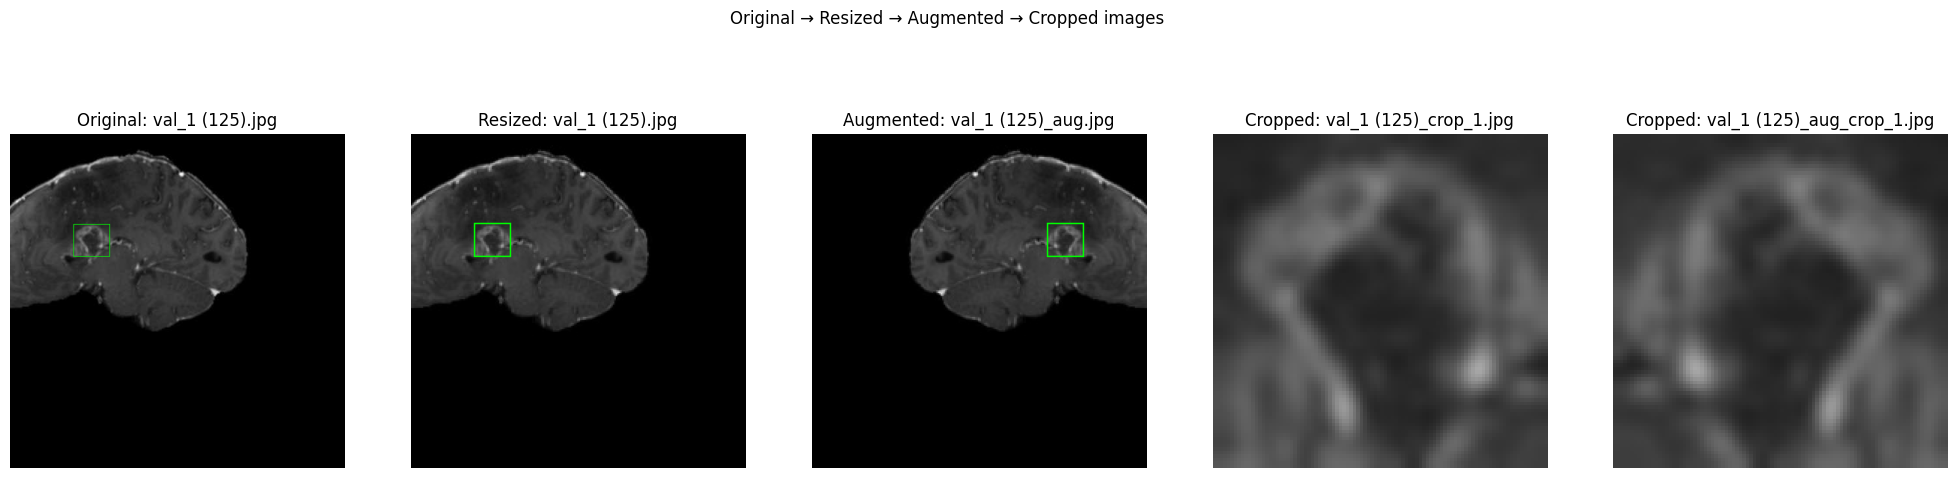

In [16]:
visualize_random_image(cnn1_valid_df, cnn2_valid_df)

# MODEL BUILDING

## CNN1 - Localization

In [21]:
# ---------------------------------------------------------------------------
# PARAMETERS (assumed defined earlier in your preprocessing code)
# ---------------------------------------------------------------------------
# IMG_SIZE = 224          # Size for CNN1 images
# BATCH_SIZE = 32         # Batch size for training
# N = 3                   # Fixed number of bounding boxes per image

# ---------------------------------------------------------------------------
# Finite Generator for CNN1 (using pre-padded data from your dataframe)
# ---------------------------------------------------------------------------
def cnn1_generator_finite(df, batch_size=BATCH_SIZE):
    """
    A finite generator that yields a batch of images and corresponding labels for CNN1.

    Assumes that each row in df has:
      - "Image Path": path to a resized image (224x224)
      - "Bboxes": list of exactly N bounding boxes, each [x1, y1, x2, y2]
      - "Confidence Scores": list of exactly N confidence scores.

    The label for each image is constructed by concatenating each bounding box with
    its confidence score, resulting in shape (N,5).
    """
    image_paths = df["Image Path"].values
    bboxes_list = df["Bboxes"].values       # Each element is a list of N bounding boxes
    confs_list  = df["Confidence Scores"].values  # Each element is a list of N confidence scores
    total_samples = len(df)

    for start_idx in range(0, total_samples, batch_size):
        batch_imgs = []
        batch_labels = []
        end_idx = min(start_idx + batch_size, total_samples)
        for i in range(start_idx, end_idx):
            # Load and preprocess image
            img = cv2.imread(image_paths[i])
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
            batch_imgs.append(img)

            # Combine each bounding box with its confidence (they are already padded)
            label = []
            for j in range(len(bboxes_list[i])):
                label.append(bboxes_list[i][j] + [confs_list[i][j]])
            batch_labels.append(label)

        yield np.array(batch_imgs, dtype=np.float32), np.array(batch_labels, dtype=np.float32)

# ---------------------------------------------------------------------------
# Create tf.data.Datasets for CNN1 training and validation
# ---------------------------------------------------------------------------
train_steps_cnn1 = math.ceil(len(cnn1_train_df) / BATCH_SIZE)
valid_steps_cnn1 = math.ceil(len(cnn1_valid_df) / BATCH_SIZE)

train_cnn1_ds = tf.data.Dataset.from_generator(
    lambda: cnn1_generator_finite(cnn1_train_df, batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, N, 5])
).repeat().prefetch(tf.data.AUTOTUNE)

valid_cnn1_ds = tf.data.Dataset.from_generator(
    lambda: cnn1_generator_finite(cnn1_valid_df, batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, N, 5])
).repeat().prefetch(tf.data.AUTOTUNE)

# ---------------------------------------------------------------------------
# Build CNN1 Model for Localization
# ---------------------------------------------------------------------------
def build_cnn1_model(img_size=224, num_boxes=N):
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))

    # Simple CNN architecture; adjust filters/depth as needed.
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Output: num_boxes * 5 values
    x = tf.keras.layers.Dense(num_boxes * 5, activation='linear')(x)
    outputs = tf.keras.layers.Reshape((num_boxes, 5))(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model

# ---------------------------------------------------------------------------
# Custom Localization Loss Function
# ---------------------------------------------------------------------------
def localization_loss(y_true, y_pred):
    """
    Computes loss for CNN1 localization.
    Both y_true and y_pred have shape (batch, N, 5) where each bounding box is:
    [x1, y1, x2, y2, confidence].

    - Uses MSE for the 4 coordinates.
    - Uses Binary Crossentropy for the confidence scores.
    Loss is averaged over N boxes and the batch.
    """
    # Extract coordinates (first 4 values)
    true_coords = y_true[:, :, :4]
    pred_coords = y_pred[:, :, :4]
    # Extract confidence (last value)
    true_conf = y_true[:, :, 4]
    pred_conf = y_pred[:, :, 4]

    # MSE for coordinates; result shape: (batch, N)
    coord_loss = tf.reduce_mean(tf.square(true_coords - pred_coords), axis=-1)
    # Average coordinate loss over N boxes: shape (batch,)
    coord_loss = tf.reduce_mean(coord_loss, axis=-1)

    # Compute BCE for confidence.
    # Create a BCE instance with reduction=NONE so that output is (batch, N)
    bce_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    conf_loss = bce_fn(true_conf, tf.nn.sigmoid(pred_conf))
    # Average confidence loss over N boxes: shape (batch,)
    conf_loss = tf.reduce_mean(conf_loss, axis=-1)

    total_loss = coord_loss + conf_loss
    return tf.reduce_mean(total_loss)

# ---------------------------------------------------------------------------
# Build and Compile CNN1 Model
# ---------------------------------------------------------------------------
cnn1_model = build_cnn1_model(IMG_SIZE, N)
cnn1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=localization_loss)
cnn1_model.summary()

# ---------------------------------------------------------------------------
# Train CNN1 Model
# ---------------------------------------------------------------------------
history_cnn1 = cnn1_model.fit(
    train_cnn1_ds,
    validation_data=valid_cnn1_ds,
    epochs=50,
    steps_per_epoch=train_steps_cnn1,
    validation_steps=valid_steps_cnn1
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           1,935 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 3, 5)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,448,175 (24.60 MB)

 Trainable params: 6,448,175 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.4349 - val_loss: 0.2302
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.2499 - val_loss: 0.1969
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2285 - val_loss: 0.1798
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.2105 - val_loss: 0.1687
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1970 - val_loss: 0.1604
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1825 - val_loss: 0.1561
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.1744 - val_loss: 0.1505
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1648 - val_loss: 0.1470
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1561 - val_loss: 0.1432
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1485 - val_loss: 0.1415
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.1413 - val_loss: 0.1399
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step

Sample 1 Ground Truth Boxes:
[0.29, 0.4, 0.36, 0.52, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
Predicted Boxes:
[0.29, 0.34, 0.5, 0.47, 11.34]
[0.01, -0.04, -0.01, -0.01, -11.36]
[-0.02, 0.01, -0.01, 0.02, -12.45]

Sample 2 Ground Truth Boxes:
[0.64, 0.4, 0.71, 0.52, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
Predicted Boxes:
[0.26, 0.31, 0.44, 0.34, 8.5]
[0.01, 0.01, 0.03, -0.01, -8.31]
[0.01, -0.0, 0.01, 0.01, -9.37]

Sample 3 Ground Truth Boxes:
[0.58, 0.35, 0.7, 0.45, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
Predicted Boxes:
[0.54, 0.27, 0.61, 0.43, 10.07]
[-0.05, 0.02, -0.03, -0.03, -10.39]
[-0.03, -0.03, -0.0, 0.01, -10.84]


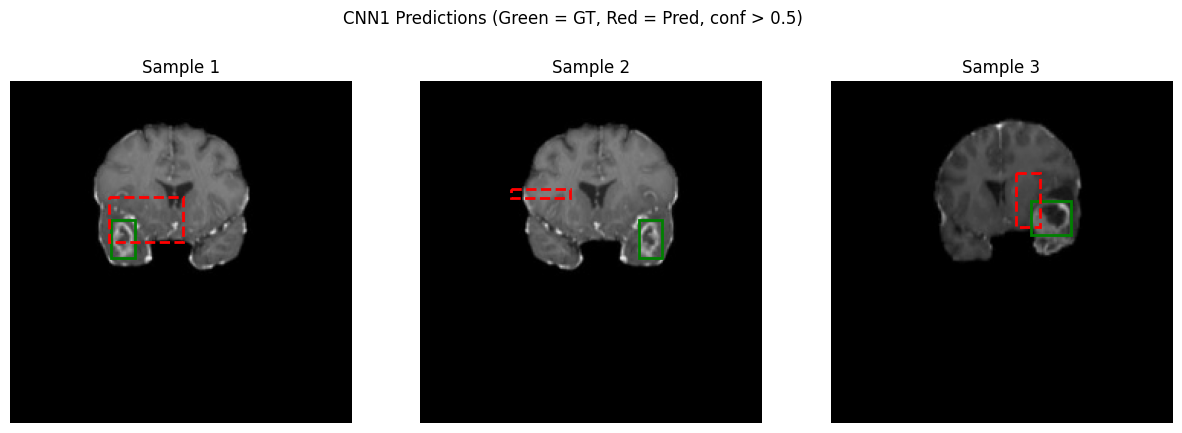

In [22]:
def visualize_cnn1_predictions_side_by_side(model, dataset, num_samples=3):
    """
    Visualizes a few samples from the dataset:
      - Draws ground truth boxes (in green) and predicted boxes (in red dashed)
      - Prints out the box coordinates and confidence scores for debugging.
    Assumes boxes are in normalized space [0..1].
    """
    batch_imgs, batch_labels = next(iter(dataset))  # Get one batch
    preds = model.predict(batch_imgs)               # shape: (batch, N, 5)

    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5))
    for i in range(num_samples):
        ax = axes[i]
        img = batch_imgs[i].numpy()  # shape: (224,224,3), normalized
        true_boxes = batch_labels[i].numpy()  # shape (N,5), normalized coords
        pred_boxes = preds[i]                 # shape (N,5), normalized coords

        print(f"\nSample {i+1} Ground Truth Boxes:")
        for box in true_boxes:
            print([round(float(v), 2) for v in box])
        print("Predicted Boxes:")
        for box in pred_boxes:
            print([round(float(v), 2) for v in box])

        ax.imshow(img)
        # Draw GT boxes in green (if confidence > 0)
        for box in true_boxes:
            x1_norm, y1_norm, x2_norm, y2_norm, conf = box
            if conf > 0:
                x1_px = x1_norm * IMG_SIZE
                y1_px = y1_norm * IMG_SIZE
                x2_px = x2_norm * IMG_SIZE
                y2_px = y2_norm * IMG_SIZE
                rect = plt.Rectangle((x1_px, y1_px), (x2_px - x1_px), (y2_px - y1_px),
                                     edgecolor='g', facecolor='none', linewidth=2)
                ax.add_patch(rect)

        # Draw predicted boxes in red dashed (if sigmoid(conf) > 0.5)
        for box in pred_boxes:
            x1_norm, y1_norm, x2_norm, y2_norm, conf = box
            if tf.nn.sigmoid(conf) > 0.5:
                x1_px = x1_norm * IMG_SIZE
                y1_px = y1_norm * IMG_SIZE
                x2_px = x2_norm * IMG_SIZE
                y2_px = y2_norm * IMG_SIZE
                rect = plt.Rectangle((x1_px, y1_px), (x2_px - x1_px), (y2_px - y1_px),
                                     edgecolor='r', facecolor='none', linewidth=2, linestyle='--')
                ax.add_patch(rect)
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')
    plt.suptitle("CNN1 Predictions (Green = GT, Red = Pred, conf > 0.5)")
    plt.show()


visualize_cnn1_predictions_side_by_side(cnn1_model, valid_cnn1_ds, num_samples=3)

In [18]:
import numpy as np

def iou_single(boxA, boxB):
    """
    Computes IoU for two boxes in pixel space:
    boxA, boxB: [x1, y1, x2, y2]
    """
    x1A, y1A, x2A, y2A = boxA
    x1B, y1B, x2B, y2B = boxB

    # Intersection
    interX1 = max(x1A, x1B)
    interY1 = max(y1A, y1B)
    interX2 = min(x2A, x2B)
    interY2 = min(y2A, y2B)

    interW = max(0, interX2 - interX1)
    interH = max(0, interY2 - interY1)
    interArea = interW * interH

    # Areas
    areaA = (x2A - x1A) * (y2A - y1A)
    areaB = (x2B - x1B) * (y2B - y1B)

    unionArea = areaA + areaB - interArea
    if unionArea <= 0:
        return 0.0
    return interArea / unionArea

def compute_mean_iou(model, dataset, num_batches=10):
    """
    Computes average IoU for up to 'num_batches' from your dataset.
    Ignores confidence. Compares box i to box i (1-to-1).
    """
    total_iou = 0.0
    total_samples = 0

    dataset_iter = iter(dataset)  # create an iterator
    for _ in range(num_batches):
        try:
            batch_imgs, batch_labels = next(dataset_iter)  # get next batch
        except StopIteration:
            break  # no more data
        preds = model.predict(batch_imgs)  # shape: (batch_size, N, 5)

        batch_size = batch_imgs.shape[0]
        for i in range(batch_size):
            gt_boxes = batch_labels[i].numpy()  # shape (N,5)
            pred_boxes = preds[i]               # shape (N,5)

            # We'll do a naive one-to-one IoU comparison
            ious_for_sample = []
            for n in range(N):
                # Ground truth coords
                x1t, y1t, x2t, y2t, conf_t = gt_boxes[n]
                # Predicted coords
                x1p, y1p, x2p, y2p, conf_p = pred_boxes[n]

                # Compute IoU
                iou_val = iou_single([x1t,y1t,x2t,y2t], [x1p,y1p,x2p,y2p])
                ious_for_sample.append(iou_val)

            # Average IoU for this sample
            sample_iou = np.mean(ious_for_sample)
            total_iou += sample_iou
            total_samples += 1

    if total_samples == 0:
        return 0.0
    return total_iou / total_samples

# Example usage:
mean_iou = compute_mean_iou(cnn1_model, valid_cnn1_ds, num_batches=10)
print(f"Mean IoU on validation (first 10 batches): {mean_iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mean IoU on validation (first 10 batches): 0.0289


In [21]:
'''
#Initializing the CNN
cnn1 = tf.keras.models.Sequential()
# Explicitly define the input layer
cnn1.add(tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
#First Convolution Layer
cnn1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#Second Convolution layer
cnn1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#Third Convolution layer
cnn1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#Flattening
cnn1.add(tf.keras.layers.Flatten())
#Full Connection
cnn1.add(tf.keras.layers.Dense(units=128, activation='relu'))
#Output Layer
cnn1.add(tf.keras.layers.Dense(units=N*5, activation='linear'))
cnn1.add(tf.keras.layers.Reshape((N, 5)))

cnn1.compile(optimizer = 'adam', loss = localization_loss)
'''

"\n#Initializing the CNN\ncnn1 = tf.keras.models.Sequential()\n# Explicitly define the input layer\ncnn1.add(tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))\n#First Convolution Layer\ncnn1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))\ncnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))\n#Second Convolution layer\ncnn1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))\ncnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))\n#Third Convolution layer\ncnn1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))\ncnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))\n#Flattening\ncnn1.add(tf.keras.layers.Flatten())\n#Full Connection\ncnn1.add(tf.keras.layers.Dense(units=128, activation='relu'))\n#Output Layer\ncnn1.add(tf.keras.layers.Dense(units=N*5, activation='linear'))\ncnn1.add(tf.keras.layers.Reshape((N, 5)))\n\ncnn1.compile(optimizer = 'adam', loss = localization_loss)\n"